<a href="https://colab.research.google.com/github/inspire-lab/CyberAI-labs/blob/main/category-SecureAI/Evasion-attack-on-CNN/attack_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attacking a CNN

In this exercise we will train a CNN to distinguish between instances of handwritten `0` and instances of handwritten `1`. We will be using `keras` to do this.  

Once we have a trained classifier, we will be using `art` library to create adversarial examples.

In [ ]:
!pip install adversarial-robustness-toolbox

import warnings
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from art.attacks.evasion import FastGradientMethod, CarliniL2Method
from art.estimators.classification import KerasClassifier
from art.utils import to_categorical as art_to_categorical

The MNIST dataset contains data for all of the digits, but for now we are only interested in 1s and 0s. Therefore we are extracting only those from the dataset.

We also need to normalize the data. This means that whatever interval was previously covered by the input values will be squashed to `[0,1]`

In [ ]:
def extract_ones_and_zeroes(data, labels):
    data_zeroes = data[np.argwhere(labels == 0).reshape(-1)][:200]
    print(data_zeroes.shape)
    data_ones = data[np.argwhere(labels == 1).reshape(-1)][:200]
    x = np.vstack((data_zeroes, data_ones))

    # Normalize the data
    x = x / 255.0

    labels_zeroes = np.zeros(data_zeroes.shape[0])
    labels_ones = np.ones(data_ones.shape[0])
    y = np.append(labels_zeroes, labels_ones)

    return x, y

Load the actual data and use our preprocessing function from earlier.

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Extract ones and zeroes
x_train, y_train = extract_ones_and_zeroes(x_train, y_train)
x_test, y_test = extract_ones_and_zeroes(x_test, y_test)

(200, 28, 28)
(200, 28, 28)


The following code prepares the data for use in a Convolutional Neural Network (CNN). It converts the class labels (e.g., 0 and 1) into a one-hot encoded format, which is a standard way of representing categorical labels for machine learning models. Additionally, it reshapes the image data to include a channel dimension (28x28x1), making it compatible with the input requirements of CNNs, which process images as multi-dimensional arrays with height, width, and channels (e.g., grayscale has one channel).

In [ ]:
# Prepare data for CNN
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

In [ ]:
print(y_train.shape)  # Should output (number_of_samples, 2)
print(y_test.shape)   # Should output (number_of_samples, 2)

(400, 2)
(400, 2)


We are using a very simple CNN. For our two output classes this is probably overkill. This network can be used to distinguish between all 10 classes with very high accuracy.

In [ ]:
# Define the classifier
clf = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

clf.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

clf.fit(x_train, y_train, epochs=2, verbose=1)

score = clf.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Train on 400 samples
Epoch 1/2
400/400 [==============================] - 1s 4ms/sample - loss: 0.1416 - accuracy: 0.9675
Epoch 2/2
400/400 [==============================] - 1s 2ms/sample - loss: 0.0452 - accuracy: 0.9875


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Test loss: 0.004310095234395703
Test accuracy: 1.0


Let's get to the actual attack magic. First we are picking a sample that we want to perturbate. After selecting the sample, we will use the FGSM attack and the Carlini & Wagner L2 attack to perturbate it into an adversarial example.

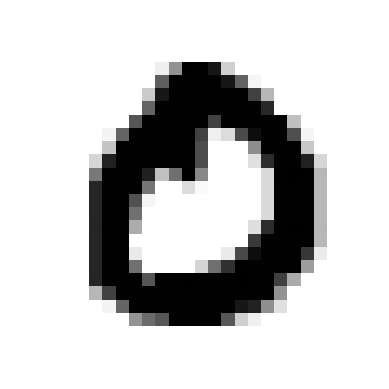

Class prediction for the modified test sample: [1]


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


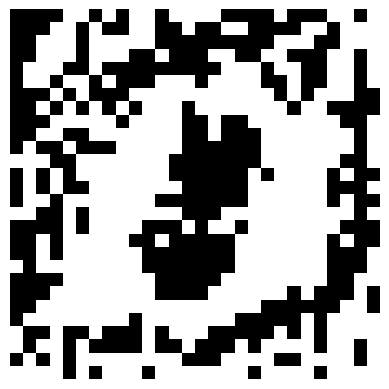

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

Class prediction for the CW modified test sample: [0]


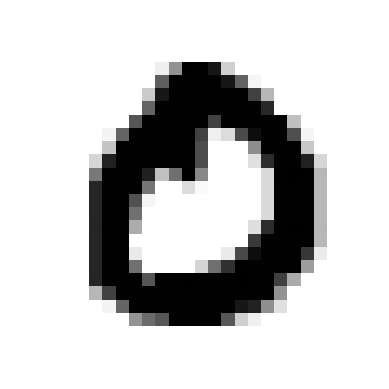

In [ ]:
# Wrapping the model for adversarial attacks
art_clf = KerasClassifier(model=clf, clip_values=(0, 1))

# Choose a sample to perturb
sample_ind = 100
sample = x_test[sample_ind]

# Display the original sample
plt.imshow(sample.reshape(28, 28), cmap="gray_r")
plt.axis('off')
plt.show()

# FGSM attack
fgm = FastGradientMethod(estimator=art_clf, eps=1.0)
modified_sample = fgm.generate(x=sample.reshape(1, 28, 28, 1))

print('Class prediction for the modified test sample:',
      np.argmax(clf.predict(modified_sample), axis=1))
plt.imshow(modified_sample.reshape(28, 28), cmap="gray_r")
plt.axis('off')
plt.show()

# CW-L2 attack
cw = CarliniL2Method(classifier=art_clf, confidence=0.1)
modified_sample_cw = cw.generate(x=sample.reshape(1, 28, 28, 1))

print('Class prediction for the CW modified test sample:',
      np.argmax(clf.predict(modified_sample_cw), axis=1))
plt.imshow(modified_sample_cw.reshape(28, 28), cmap="gray_r")
plt.axis('off')
plt.show()